In [53]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

In [54]:
np.random.seed(1)

def sigmoid(input_sum):
    # 激活函数的运算
    # 输入为对上一层的加权求和，输出为经过激活函数后的值
    output = 1.0/(1+np.exp(-input_sum))
    return output,input_sum

def sigmoid_back_propagation(derror_wrt_output,input_sum):
    # 求误差关于神经元输入的偏导
    # 输入为传来的误差和上一层的加权求和，输出为误差关于输入的偏导
    output = 1.0/(1+np.exp(-input_sum))
    doutput_wrt_dinput = output*(1-output)  # 输出对输入的求导
    derror_wrt_dinput = derror_wrt_output * doutput_wrt_dinput # 误差对输入的求导
    
    return derror_wrt_dinput

def relu(input_sum):
    # 激活函数ReLU
    # 输入为神经元加权和、输出为激活后的输出
    output = np.maximum(0,input_sum)
    return output,input_sum

def relu_back_propagation(derror_wrt_output,input_sum):
    # 求误差关于神经元输入的偏导
    # 输入为误差关于神经元输出的偏导，输出为误差关于输入的偏导
    derror_wrt_dinputs = np.array(derror_wrt_output,copy=True)
    derror_wrt_dinputs[input_sum <=0] = 0
    
    return derror_wrt_dinputs

def tanh(input_sum):
    # 激活函数tanh
    # 输入为神经元的加权和，输出为激活后的输出
    output = np.tanh(input_sum)
    return output,input_sum

def tanh_back_propagation(derror_wrt_output,input_sum):
    # 误差关于神经元输入的偏导
    # 输入为误差关于神经元输出的偏导，输出为误差关于输入的偏导
    output = np.tanh(input_sum)
    doutput_wrt_dinput = 1 - np.power(output,2)
    derror_wrt_dinput = derror_wrt_output * doutput_wrt_dinput
    
    return derror_wrt_dinput

def activated(activation_choose,input):
    # 包装正向激活函数
    if activation_choose == "sigmoid":
        return sigmoid(input)
    elif activation_choose == "relu":
        return relu(input)
    elif activation_choose == "tanh":
        return tanh(input)
    return sigmoid(input)

def activated_back_propagation(activation_choose,derror_wrt_output,output):
    # 包装反向误差传播
    if activation_choose == "sigmoid":
        return sigmoid_back_propagation(derror_wrt_output,output)
    elif activation_choose == "relu":
        return relu_back_propagation(derror_wrt_output,output)
    elif activation_choose == "tanh":
        return tanh_back_propagation(derror_wrt_output,output)
    
    return sigmoid_back_propagation(derror_wrt_output,output)

class NeuralNetwork:
    def __init__(self,layers_structure,print_cost = False):
        self.layers_structure = layers_structure
        self.layers_num = len(layers_structure)
        
        self.param_layers_num = self.layers_num - 1  # 去除输入层的网络层数
        
        self.learning_rate = 0.0618
        self.num_iterations = 2000
        self.x = None
        self.y = None
        self.w = dict()
        self.b = dict()
        self.costs = []
        self.print_cost = print_cost
        
        self.init_w_and_b()
    
    def set_learning_rate(self,learning_rate):
        # 设置学习率
        self.learning_rate = learning_rate
    
    def set_num_iterations(self,num_iterations):
        # 设置迭代次数
        self.num_iterations = num_iterations
        
    def set_xy(self,input,expected_output):
        # 设置神经网络的输入和期望的输出
        self.x = input
        self.y = expected_output
        
    def init_w_and_b(self):
        # 初始化神经网络所有参数
        # 输入为神经网络的结构,返回神经网络各层参数索引表
        
        np.random.seed(3)
        for l in range(1,self.layers_num):
            self.w["w" + str(l)] = np.random.randn(self.layers_structure[l],self.layers_structure[l-1])/np.sqrt(self.layers_structure[l-1])
            self.b["b" + str(l)] = np.zeros((self.layers_structure[l],1))
            
        return self.w,self.b
    
    def layer_activation_forward(self,x,w,b,activation_choose):
        # 网络层的正向传播
        # 输入为当前网络层的输入。w为当前网络层的权重矩阵，b为当前网络层的偏执矩阵，输出为网络层的激活输出
        input_sum = np.dot(w,x) + b
        output,_ = activated(activation_choose,input_sum)
        
        return output,(x,w,b,input_sum)
    
    def forward_propagation(self,x):
        # 神经网络的正向传播，输入为x，输出为传播完成后的输出层输出
        
        caches = []
        output_prev = x # 输入层，前一层的输出即为后一层的输入，第一次的时候就是x
        
        L = self.param_layers_num
        for l in range(1,L):
            input_cur = output_prev
            output_prev,cache = self.layer_activation_forward(input_cur,self.w["w"+str(l)],self.b["b" + str(l)],"tanh")
            caches.append(cache)  # cache里包括了x，w，b，input_sum
        output,cache = self.layer_activation_forward(output_prev,self.w["w" + str(L)],self.b["b" + str(L)],"sigmoid")
        
        caches.append(cache)
        
        return output,caches
    
    def show_caches(self,caches):
        # 显示网络层的缓存参数信息
        i = 1
        for cache in caches:
            print("%dtd Layer" % i)
            print(" input: %s" % cache[0])
            print(" w: %s" % cache[1])
            print(" b: %s" % cache[2])
            print(" input_sum: %s" % chache[3])
            print("--------------------")
            i += 1
            
    def compute_error(self,output):
        # 用于计算当次迭代的输出总误差
        
        m = self.y.shape[1]  # m为标签的种类数
        
        error = -np.sum(np.multiply(np.log(output),self.y) + np.multiply(np.log(1-output),1-self.y)) / m
        error = np.squeeze(error)
        
        return error

    def layer_activation_backward(self,derror_wrt_doutput,cache,activation_choose):
        # 用于网络层反向传播
        # 输入为误差关于输出的偏导，网络缓存信息，返回梯度信息
        input,w,b,input_sum = cache
        output_prev = input
        
        m = output_prev.shape[1]  # m是输入的值的个数
        
        derror_wrt_dinput = activated_back_propagation(activation_choose,derror_wrt_doutput,input_sum)
        derror_wrt_dw = np.dot(derror_wrt_dinput,output_prev.T) / m   # 直接进行了内积运算，再取均值
        
        derror_wrt_db = np.sum(derror_wrt_dinput,axis=1,keepdims=True)/m
        
        derror_wrt_output_prev = np.dot(w.T,derror_wrt_dinput) # 内积
        
        return derror_wrt_output_prev,derror_wrt_dw,derror_wrt_db
        
    def back_propagation(self,output,caches):
        # 用于神经网络的反向传播
        # 输入为神经网络输出、所有网络层缓存参数信息，当前迭代的梯度信息
        grads = {}
        L = self.param_layers_num
        output = output.reshape(output.shape)
        
        expected_output = self.y
        
        # 交叉熵函数求导
        derror_wrt_output = - (np.divide(expected_output,output) - np.divide(1-expected_output,1-output))
        
        # 反向传播:从输出层到输入层
        current_cache = caches[L-1]  # 取输出层外最后一层
        grads["derror_wrt_output" + str(L)],grads["derror_wrt_dw" + str(L)],grads["derror_wrt_db" + str(L)] = \
            self.layer_activation_backward(derror_wrt_output,current_cache,"sigmoid") # 分别是下一层的输出的导数、对w的导数、对b的导数
        
        # 反向传播
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            derror_wrt_output_prev_temp,derror_wrt_dw_temp,derror_wrt_db_temp = \
                self.layer_activation_backward(grads["derror_wrt_output" + str(l+2)],current_cache,"tanh")
            
            grads["derror_wrt_output" + str(l + 1)] = derror_wrt_output_prev_temp
            grads["derror_wrt_dw" + str(l + 1)] = derror_wrt_dw_temp
            grads["derror_wrt_db" + str(l + 1)] = derror_wrt_db_temp
        
        return grads
    
    def update_w_and_b(self,grads):
         # 根据梯度信息更新w和b
        for l in range(self.param_layers_num):
            self.w["w" + str(l + 1)] = self.w["w" + str(l + 1)] - self.learning_rate * grads["derror_wrt_dw" + str(l + 1)]
            self.b["b" + str(l + 1)] = self.b["b" + str(l + 1)] - self.learning_rate * grads["derror_wrt_db" + str(l + 1)]
            
    def training_model(self):
        np.random.seed(5)
        for i in range(0,self.num_iterations):
            output,caches = self.forward_propagation(self.x)
            
            cost = self.compute_error(output)
            
            grads = self.back_propagation(output,caches)
            
            self.update_w_and_b(grads)
            
            if self.print_cost and i % 1000 == 0:
                print("Cost after iteration %i:%f" % (i,cost))
            if self.print_cost and i % 1000 == 0:
                self.costs.append(cost)
                
        if False:
            plt.plot(np.squeeze(self.costs))
            plt.ytabel(u'神经网络误差',fontproperties = font)
            plt.xlabel(u'迭代次数(*100)',fontpropertires = font)
            plt.title(u"学习率=" + str(self.learning_rate),fontproperties = font)
            plt.show()

        return self.w,self.b
    
    def predict_by_model(self,x):
        output,_ = self.forward_propagation(x.T)
        output = output.T
        result = output / np.sum(output,axis=1,keepdims=True)
        return np.argmax(result,axis=1)
    
def plot_decision_boundary(xy,colors,pred_func):
    # xy是坐标点的集合，把集合的范围算出来
    # 加减0.5相当于扩大画布的范围，不然画出来的图坐标点会落在图的边缘，逼死强迫症患者
    x_min, x_max = xy[:, 0].min() - 0.5, xy[:, 0].max() + 0.5
    y_min, y_max = xy[:, 1].min() - 0.5, xy[:, 1].max() + 0.5
    
    # 以h为分辨率，生成采样点的网格，就像一张网覆盖所有颜色点 
    h = .01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # 把网格点集合作为输入到模型，也就是预测这个采样点是什么颜色的点，从而得到⼀个决策 
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 利用等高线，把预测的结果画出来，效果上就是画出红蓝点的分界
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    # 训练用的红蓝点点也画出来
    plt.scatter(xy[:, 0], xy[:, 1], c=colors, marker='o', cmap=plt.cm.Spectral,
edgecolors='black')

Cost after iteration 0:1.838907
Cost after iteration 1000:0.847668
Cost after iteration 2000:0.847476
Cost after iteration 3000:0.847473
Cost after iteration 4000:0.847473
Cost after iteration 5000:0.847473
Cost after iteration 6000:0.847473
Cost after iteration 7000:0.847473
Cost after iteration 8000:0.847473
Cost after iteration 9000:0.847473
Cost after iteration 10000:0.847473
Cost after iteration 11000:0.847473
Cost after iteration 12000:0.847473
Cost after iteration 13000:0.847473
Cost after iteration 14000:0.847473
Cost after iteration 15000:0.847473
Cost after iteration 16000:0.847473
Cost after iteration 17000:0.847473
Cost after iteration 18000:0.847473
Cost after iteration 19000:0.847473
Cost after iteration 20000:0.847473
Cost after iteration 21000:0.847473
Cost after iteration 22000:0.847473
Cost after iteration 23000:0.847473
Cost after iteration 24000:0.847473
Cost after iteration 25000:0.847473
Cost after iteration 26000:0.847473
Cost after iteration 27000:0.847473
Cost 

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in multiply
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:184: RuntimeWarning: invalid value encountered in true_divide


Cost after iteration 16000:nan
Cost after iteration 17000:nan
Cost after iteration 18000:nan
Cost after iteration 19000:nan
Cost after iteration 20000:nan
Cost after iteration 21000:nan
Cost after iteration 22000:nan
Cost after iteration 23000:nan
Cost after iteration 24000:nan
Cost after iteration 25000:nan
Cost after iteration 26000:nan
Cost after iteration 27000:nan
Cost after iteration 28000:nan
Cost after iteration 29000:nan


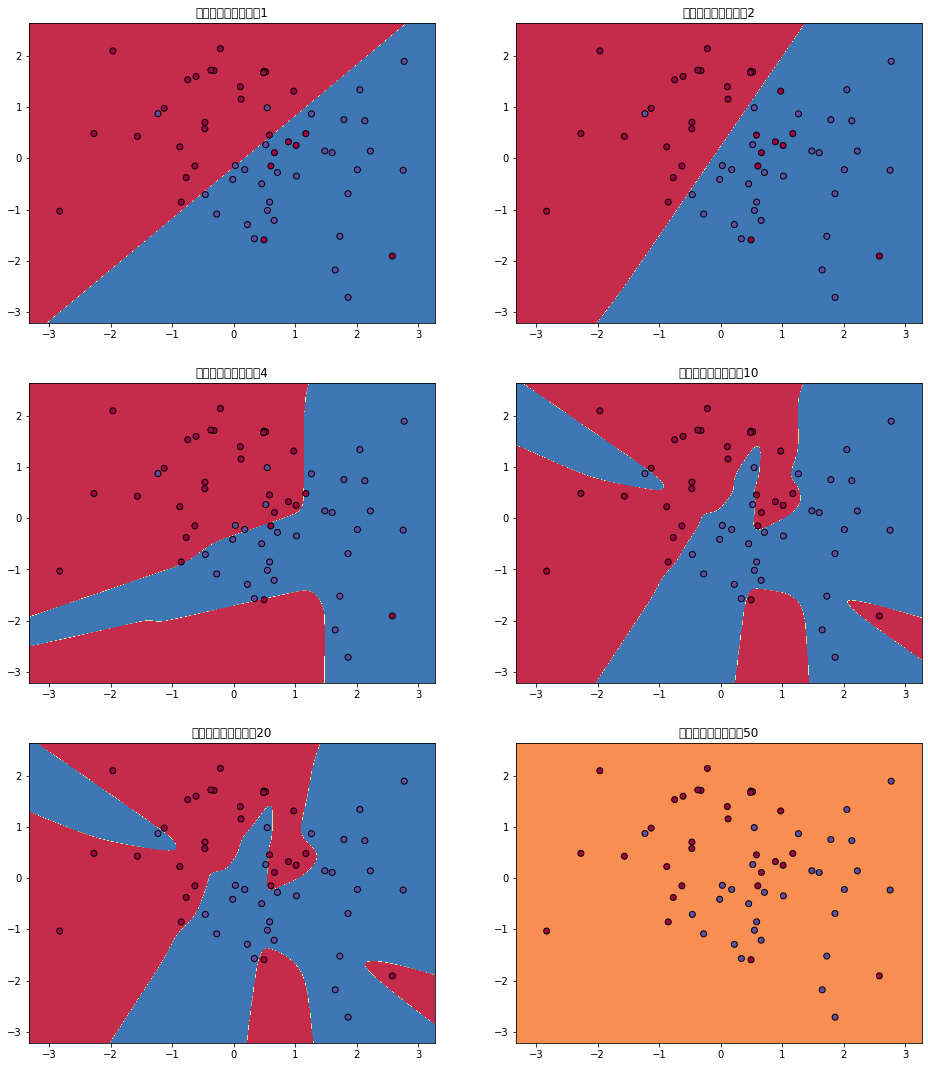

In [55]:
if __name__=="__main__":
    plt.figure(figsize=(16,32))
    # 使用sklearn数据样本集，产生两种颜色坐标点，噪声越大，分布越凌乱
    xy,colors = sklearn.datasets.make_moons(60,noise=1.0)
    
    # 点的颜色是1bit，输出层有两个神经元即可
    # 输出[1,0]是红色点，输出[0,1]为蓝色点
    expect_output = []
    for c in colors:
        if c == 1:
            expect_output.append([0,1])
        else:
            expect_output.append([1,0])
    expect_output = np.array(expect_output).T
    
    # 设计了三层网络，改变隐藏层神经元个数，观察神经网络分类红蓝点的效果
    hidden_layer_neuron_num_list = [1,2,4,10,20,50]
    for i,hidden_layer_neuron_num in enumerate(hidden_layer_neuron_num_list):
        plt.subplot(5,2,i+1)  # 共五行两列图，这是第i+1个图
        plt.title(u"隐藏层神经元数量：%d" % hidden_layer_neuron_num)
        
        nn = NeuralNetwork([2,hidden_layer_neuron_num,2],True) # 参数是网络结构,[2,隐层神经元个数,2]
        
        nn.set_xy(xy.T,expect_output)
        nn.set_num_iterations(30000)
        nn.set_learning_rate(0.1)
        w,b = nn.training_model()
        plot_decision_boundary(xy,colors,nn.predict_by_model)
        
    plt.show()